# GLM: Mini-batch ADVI on hierarchical regression model

:::{post} Sept 23, 2021
:tags: generalized linear model, hierarchical model, pymc3.Minibatch, pymc3.Model, pymc3.NUTS, pymc3.Normal, pymc3.Uniform, variational inference
:category: intermediate
:::

Unlike Gaussian mixture models, (hierarchical) regression models have independent variables. These variables affect the likelihood function, but are not random variables. When using mini-batch, we should take care of that.

In [1]:
%env AESARA_FLAGS=device=cpu, floatX=float32, warn_float64=ignore

import os

import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

print(f"Running on PyMC v{pm.__version__}")

env: AESARA_FLAGS=device=cpu, floatX=float32, warn_float64=ignore
Running on PyMC v4.0.0b6


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
pm.set_at_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
try:
    data = pd.read_csv(os.path.join("..", "data", "radon.csv"))
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("radon.csv"))

data

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,914,5995.0,MN,MN,27.0,55363,5.0,1.0,0.0,4.0,...,4.5,1146.499190,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.871802
915,915,5996.0,MN,MN,27.0,55376,5.0,1.0,0.0,7.0,...,8.3,1105.956867,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.526056
916,916,5997.0,MN,MN,27.0,55376,5.0,1.0,0.0,4.0,...,5.2,1214.922779,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.629241
917,917,5998.0,MN,MN,27.0,56297,5.0,1.0,0.0,4.0,...,9.6,1177.377355,0.0,0.0,173.0,YELLOW MEDICINE,27173.0,1.426590,84,1.335001


In [4]:
county_idx = data["county_code"].values
floor_idx = data["floor"].values
log_radon_idx = data["log_radon"].values

coords = {"counties": data.county.unique()}

Here, `log_radon_idx_t` is a dependent variable, while `floor_idx_t` and `county_idx_t` determine the independent variable.

In [5]:
log_radon_idx_t = pm.Minibatch(log_radon_idx, 100)
floor_idx_t = pm.Minibatch(floor_idx, 100)
county_idx_t = pm.Minibatch(county_idx, 100)

In [6]:
with pm.Model(coords=coords) as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=100**2)
    sigma_a = pm.Uniform("sigma_alpha", lower=0, upper=100)
    mu_b = pm.Normal("mu_beta", mu=0.0, sigma=100**2)
    sigma_b = pm.Uniform("sigma_beta", lower=0, upper=100)

Intercept for each county, distributed around group mean `mu_a`. Above we just set `mu` and `sd` to a fixed value while here we plug in a common group distribution for all `a` and `b` (which are vectors with the same length as the number of unique counties in our example).

In [7]:
with hierarchical_model:

    a = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="counties")
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="counties")

Model prediction of radon level `a[county_idx]` translates to `a[0, 0, 0, 1, 1, ...]`, we thus link multiple household measures of a county to its coefficients.

In [8]:
with hierarchical_model:

    radon_est = a[county_idx_t] + b[county_idx_t] * floor_idx_t

Finally, we specify the likelihood:

In [9]:
with hierarchical_model:

    # Model error
    eps = pm.Uniform("eps", lower=0, upper=100)

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like", mu=radon_est, sigma=eps, observed=log_radon_idx_t, total_size=len(data)
    )

Random variables `radon_like`, associated with `log_radon_idx_t`, should be given to the function for ADVI to denote that as observations in the likelihood term.

On the other hand, `minibatches` should include the three variables above.

Then, run ADVI with mini-batch.

In [10]:
with hierarchical_model:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    idata_advi = approx.sample(500)

Finished [100%]: Average Loss = 120.32
/home/ferres/dev/pymc3/pymc/backends/arviz.py:59: UserWarning: Could not extract data from symbolic observation radon_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


Check the trace of ELBO and compare the result with MCMC.

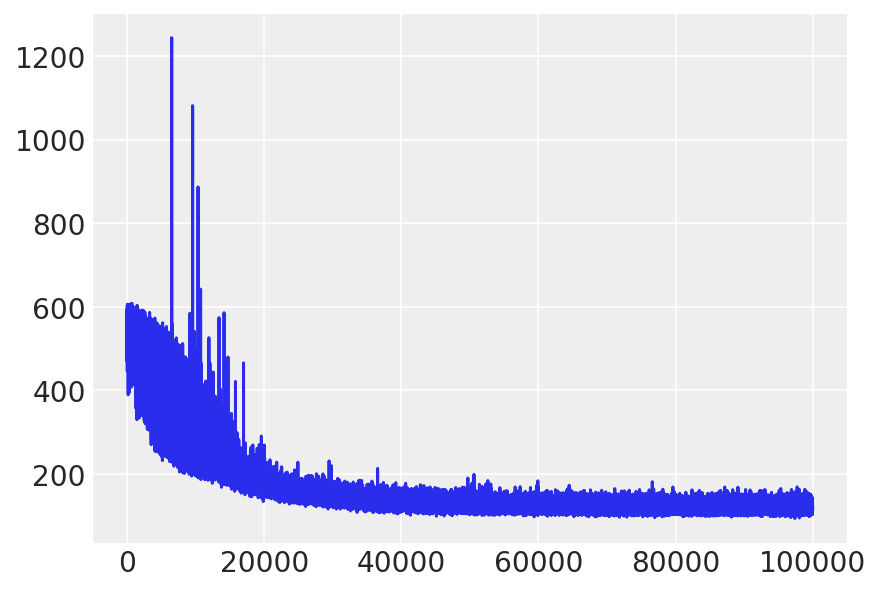

In [11]:
plt.plot(approx.hist);

In [12]:
# Inference button (TM)!
with pm.Model(coords=coords):

    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=100**2)
    sigma_a = pm.Uniform("sigma_alpha", lower=0, upper=100)
    mu_b = pm.Normal("mu_beta", mu=0.0, sigma=100**2)
    sigma_b = pm.Uniform("sigma_beta", lower=0, upper=100)

    a = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="counties")
    b = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="counties")

    # Model error
    eps = pm.Uniform("eps", lower=0, upper=100)

    radon_est = a[county_idx] + b[county_idx] * floor_idx

    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=log_radon_idx)

    # essentially, this is what init='advi' does
    step = pm.NUTS(scaling=approx.cov.eval(), is_cov=True)
    hierarchical_trace = pm.sample(
        2000,
        step,
        # sampling different initial values from the trace
        initvals=list(approx.sample(return_inferencedata=False, size=4)[i] for i in range(4)),
        progressbar=True,
        return_inferencedata=True,
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.7019, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.703, but should be close to 0.8. Try to increase the number of tuning steps.


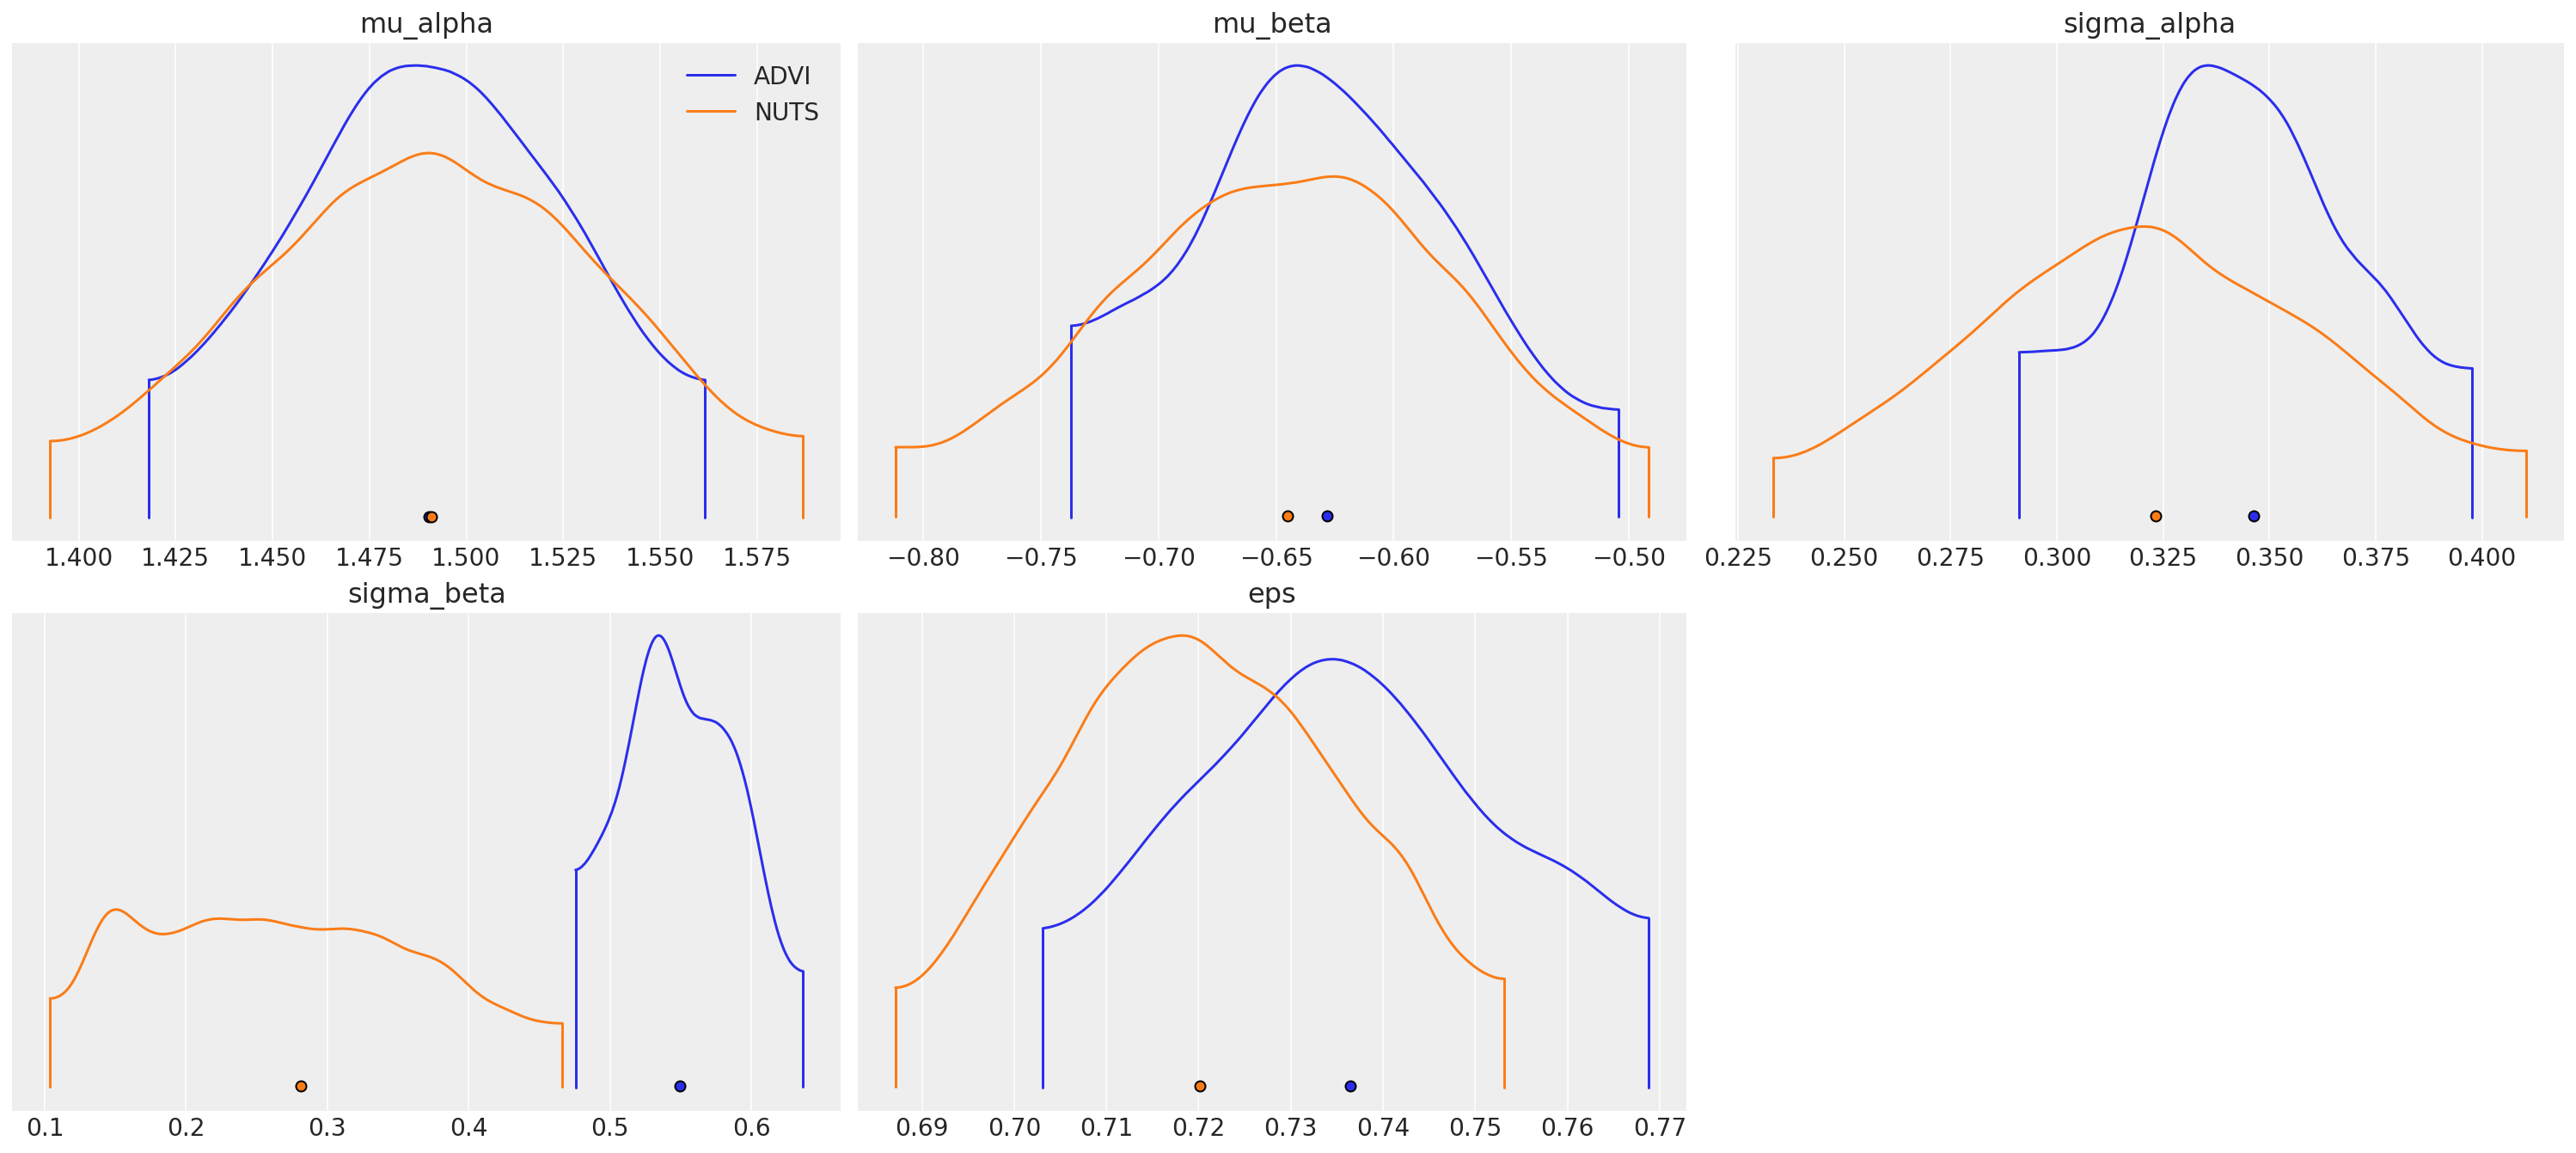

In [13]:
az.plot_density(
    [idata_advi, hierarchical_trace], var_names=["~alpha", "~beta"], data_labels=["ADVI", "NUTS"]
);

## Watermark

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Thu Jun 02 2022

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.4.0

xarray: 0.20.1

pymc      : 4.0.0b6
scipy     : None
numpy     : 1.21.4
aesara    : 2.6.2
arviz     : 0.11.4
matplotlib: 3.5.0
seaborn   : 0.11.2
pandas    : 1.3.4

Watermark: 2.3.1

